## RightMove Scrape

In [350]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

### First Scraper

**Loops through all n rightmove results pages extracting link, price and id of each property.**

1. First we define the parameters of our search i.e. the max/min price and the radius around the station.
2. Next, since the URL changes for page 1 vs pages 2+, we reconfigure the request accordingly using `if` and `elif`. The URLs have the parameters of our search inserted. 
3. Requests.get fetches the specified webpage. r objects have `.text` attributes which returns the webpage's raw html.
4. BeautifulSoup is a package which parses html and returns a `soup` object.
5. `find_all` takes a html tag as an argument ("div" here). Any argument that’s not recognized (e.g. class_) will be turned into a filter on a tag’s attributes. Here the argument class_, is used to filter against each tag’s 'class_' attribute which identifies a new property.
6. Looping through the apartments, we extract the relevant information this time using `find` and looking for the relevant info indicated by 'class_' again.
7. Appending the info at the end of each loop means we compile all the info across the webpages.

https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=STATION%5E6095&maxPrice=800000&minPrice=400000&radius=3.0&sortType=6&index=24&propertyTypes=detached%2Cflat%2Csemi-detached%2Cterraced&secondaryDisplayPropertyType=housesandflats&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=

In [351]:
# Scraping the rightmove property search results webpages 
# Collates valid properties' weblinks, plus their price and id

all_apartment_links = [] # stores apartment links
all_price = [] # stores the listing price of apartment
all_id_no = []

minPrice=450000
maxPrice=800000
radius=3

for i in range(42):
    if i==0:
        r= requests.get(f'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=STATION%5E7658&maxPrice={maxPrice}&minPrice={minPrice}&radius={radius}&sortType=6&propertyTypes=detached%2Cflat%2Csemi-detached%2Cterraced&secondaryDisplayPropertyType=housesandflats&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=')
    else:
        r = ''
        while r == '':
            try:
                r = requests.get(f'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=STATION%5E7658&maxPrice={maxPrice}&minPrice={minPrice}&radius={radius}&sortType=6&index={i*24}&propertyTypes=detached%2Cflat%2Csemi-detached%2Cterraced&secondaryDisplayPropertyType=housesandflats&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=')
                break
            except:
                print(f'Connection refused by the server on page {i+1}... sleeping for 3 seconds')
                time.sleep(3)
                print("Was a nice sleep, now let me continue...")
                continue
        #r= requests.get(f'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=STATION%5E6095&maxPrice={maxPrice}&minPrice={minPrice}&radius={radius}&sortType=6&index={i*24}&propertyTypes=detached%2Cflat%2Csemi-detached%2Cterraced&secondaryDisplayPropertyType=housesandflats&includeSSTC=false&mustHave=&dontShow=&furnishTypes=&keywords=')
    
    soup = BeautifulSoup(r.text, 'lxml')
    
    apartments = soup.find_all("div", class_="l-searchResult is-list")
    
    for i in range(len(apartments)):

        # tracks which apartment we are on in the page
        apartment_no = apartments[i]

        # append link
        apartment_info = apartment_no.find("a", class_="propertyCard-link")
        link = "https://www.rightmove.co.uk" + apartment_info.attrs["href"]
        all_apartment_links.append(link)


        # append price
        price = (
            apartment_no.find("div", class_="propertyCard-priceValue")
            .get_text()
            .strip()
        )
        all_price.append(price)
        
        # append id
        id_no = (
            apartment_no.find("div", id_="property-*")
            #.get_text()
            #.strip()
        )
        all_id_no.append(id_no)

r.ok

True

### Second Scraper

**Loops through all listing specific weblinks identified above extracting data on each property.**

In [352]:
# Scrapes individual property listing webpages based on links collated above

all_links =[]
all_features =[]
all_prices =[]
all_statname =[]
all_statdist =[]
all_outcodes = []
all_postcodes = []
all_centralities = []
all_dates = []

import re
import json
import geopy
from geopy import distance

for i in range(len(all_apartment_links)):
    
    # Progress tracker
    if i % 52 == 0:
        percent = round(i*100/1050)
        print(f'Code is {percent}% complete')
              
    r= requests.get(all_apartment_links[i])

    soup = BeautifulSoup(r.text, 'lxml')
    
    # Append variables of interest
    
    # weblink
    all_links.append(all_apartment_links[i])
    
    # physical features
    features = (
        soup.find_all("p", class_="_1hV1kqpVceE9m-QrX_hWDN")
    )
    features =[str(i).replace('<p class="_1hV1kqpVceE9m-QrX_hWDN">', '').replace('</p>', '')
     .replace('<p class="_1hV1kqpVceE9m-QrX_hWDN _2SpNNVW0fTYoFvPDmhKSt8 _3ixAp8byA3wC3qvii8d-kg">' , '') 
     for i in features]
    features =[i for i in features if "<p class" not in i ]
    all_features.append(features)
    
    # price
    price = (
        soup.find('input').attrs['value']
        #.get_text()
        #.strip()
    )
    all_prices.append(int(price.replace(",","")))
    
    # postcodes   
    links = soup.find_all('script')[4]    
    jsonobj = json.loads(links.text[25:]) # converts json into dictionary  
    outcode = jsonobj.get("propertyData").get('address').get('outcode')
    postcode = outcode + jsonobj.get("propertyData").get('address').get('incode')
    all_outcodes.append(outcode)
    all_postcodes.append(postcode)    
    
    # distance to centre of London
    latitude = float(jsonobj.get("propertyData").get('location').get('latitude'))
    longitude = float(jsonobj.get("propertyData").get('location').get('longitude'))
    coords = (latitude, longitude)
    charingX = (51.507602, -0.127816)
    centrality = geopy.distance.geodesic(coords, charingX).km
    all_centralities.append(centrality)
    
    # stations
    statdist = (
        soup.find("span", class_="_1ZY603T1ryTT3dMgGkM7Lg")
        .get_text()
        .strip()
    )
    all_statdist.append(float(statdist.replace(" miles","")))
    
    statname = (
        soup.find("span", class_="cGDiWU3FlTjqSs-F1LwK4")
        .get_text()
        .strip()
    )
    all_statname.append(statname)
    
    # Date added
    date = jsonobj.get("analyticsInfo").get('analyticsProperty').get('added')
    all_dates.append(date)

Code is 0% complete
Code is 4% complete
Code is 9% complete
Code is 14% complete
Code is 19% complete
Code is 24% complete
Code is 29% complete
Code is 34% complete
Code is 39% complete
Code is 44% complete
Code is 49% complete
Code is 54% complete
Code is 59% complete
Code is 64% complete
Code is 69% complete
Code is 74% complete
Code is 79% complete
Code is 84% complete
Code is 89% complete
Code is 94% complete
Code is 99% complete


In [353]:
# Creating floor size (sq. ft.) variable

import re
floor_size =[]
clean1= ''

for i in range(len(all_features)):
    for j in range(len(all_features[i])):
        if all_features[i][j].endswith('sq. ft.'):
            clean1 = int(re.sub("[^0-9]", "", all_features[i][j]))
            if len(str(clean1)) > 4:   # Fixes instances where floor size is a range (e.g. 439-1051 sq feet)
                clean1 = str(clean1)
                half = int(len(clean1)/2)
                clean1 = int( (int(clean1[0:half]) + int(clean1[half:len(clean1)]) ) / 2)
            elif clean1 > 3000:  # Remove floorsizes > 3000
                clean1 = np.nan
            floor_size.append(clean1)
    if len(floor_size) <= i: 
        floor_size.append(np.nan)
floor_size[:10]

[nan, nan, nan, nan, nan, nan, nan, 814, nan, nan]

In [393]:
# Keywords and Floor size (different route)

units = ['Sq ft', 'sq ft', 'Sq Ft', 'SQ FT', 'SqFt', 'sqft', 'Sqft', 'Square Feet', 'square feet', 'Square feet', 
         'square foot', 'Square foot', 'Square Foot', 'Sq. Ft.', 'sq. ft.', 'Sq. ft.', 'Sq. Ft','Sq. ft','sq. ft']

floor_size2 = []

# Extracting keywords: porter/concierge/caretaker, balcony/garden/terrace 

porter_list = ['Porter','PORTER','porter', 'Concierge','CONCIERGE','concierge','Caretaker','caretaker','CARETAKER']
outdoor_list = ['Balcony','BALCONY','balcony', 'Terrace','TERRACE','terrace', 'Patio', 'PATIO', 'patio', 'Garden', 'GARDEN', 'garden']

porter = []
outdoor = []

for i in range(len(all_apartment_links)):
    # Progress tracker
    if i % 52 == 0:
        percent = round(i*100/1050)
        print(f'Code is {percent}% complete')
    
    #r= requests.get(all_apartment_links[i])
    if i==0:
        r= requests.get(all_apartment_links[i])
    else:
        r = ''
        while r == '':
            try:
                r = requests.get(all_apartment_links[i])
                break
            except:
                print(f'Connection refused by the server on page {i+1}... sleeping for 3 seconds')
                time.sleep(3)
                print("Was a nice sleep, now let me continue...")
                continue

    soup = BeautifulSoup(r.text, 'lxml')
    
    # floor size
    lst = (soup.find_all("li", class_="lIhZ24u1NHMa5Y6gDH90A"))
    text =[str(x).replace('<li class="lIhZ24u1NHMa5Y6gDH90A">', '').replace('</li>', '') 
     for x in lst]
    floor_size2.append(np.nan)
    for j in text:
        #print(f'entry {clean1}, next text is {j}')
        if any(k in j for k in units):
            try: 
                position = j.index('sq')
            except ValueError: 
                try:
                    position = j.index('Sq')
                except ValueError: 
                    position = j.index('SQ')
                except:
                    pass
            str1 = j[0:position]
            clean1 = int(re.sub("[^0-9]", "", str1))
            if clean1 >= 3000 or clean1 <= 200:
                clean1 = np.nan
            floor_size2[i] = clean1
        else:
            clean1 = np.nan

    # keywords
    lst = (soup.find_all("li", class_="lIhZ24u1NHMa5Y6gDH90A"))
    text =[str(x).replace('<li class="lIhZ24u1NHMa5Y6gDH90A">', '').replace('</li>', '') 
     for x in lst]
    porter.append(0)
    outdoor.append(0)
    for j in text:
        if any(k in j for k in porter_list) and porter[i] < 1:
            porter[i] +=1
        if any(k in j for k in outdoor_list) and outdoor[i] < 1:
            outdoor[i] +=1

Code is 0% complete
Code is 5% complete
Code is 10% complete
Code is 15% complete
Code is 20% complete
Code is 25% complete
Code is 30% complete
Code is 35% complete
Code is 40% complete
Code is 45% complete
Code is 50% complete
Code is 54% complete
Code is 59% complete
Code is 64% complete
Code is 69% complete
Code is 74% complete
Code is 79% complete
Code is 84% complete
Code is 89% complete
Code is 94% complete
Code is 99% complete


In [389]:
clean1

nan

In [394]:
# Merge floor size lists
floor_size3 =  [None] * len(floor_size)
for i in range(len(floor_size)):
    if np.isnan(floor_size[i]) == True:
        floor_size3[i] = floor_size2[i]
    else:
        floor_size3[i] = floor_size[i]

In [395]:
# Proving the merge has worked
fs, fs2, fs3 = 0,0,0
for i in range(len(floor_size)):
    if np.isnan(floor_size[i]) == False:
        fs +=1

for i in range(len(floor_size)):
    if np.isnan(floor_size2[i]) == False:
        fs2 +=1
        
for i in range(len(floor_size)):
    if np.isnan(floor_size3[i]) == False:
        fs3 +=1

print(f'fs has {fs} entries, fs2 has {fs2} entries, combined they have {fs3} entries')

fs has 300 entries, fs2 has 125 entries, combined they have 386 entries


In [356]:
# Creating property type variable
prop_type =[]

for i in all_features:
    if i[0] in ('Apartment','Flat','Studio','Maisonette', 'House','Terraced','Mews'):
        prop_type.append(i[0])
    else: 
        prop_type.append('')

In [357]:
# Creating bedrooms & bathrooms variable
bedrooms =[]
bathrooms =[]

import numpy as np

for i in all_features:
    if i[0] == 'Studio':
        bedrooms.append(0)
        if i[1].startswith('×'):
            bathrooms.append(int(i[1][1]))
        else:
            bathrooms.append(np.nan)
    elif i[0].startswith('×') and i[1].startswith('×'): 
        bedrooms.append(int(i[0][1]))
        bathrooms.append(int(i[1][1]))
    elif len(i) <= 2:
        bedrooms.append(np.nan)
        bathrooms.append(np.nan)  
    elif i[1].startswith('×') and i[2].startswith('×'): 
        bedrooms.append(int(i[1][1]))
        bathrooms.append(int(i[2][1]))  
    else:
        bedrooms.append(np.nan)
        bathrooms.append(np.nan)

bedrooms[:20] 
#bathrooms[:20]

[1, 1, 1, 1, 2, nan, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]

In [358]:
# Extracting keywords: porter/concierge/caretaker, balcony/garden/terrace 

porter = []
outdoor = []
porter_list = ['Porter','PORTER','porter', 'Concierge','CONCIERGE','concierge','Caretaker','caretaker','CARETAKER']
outdoor_list = ['Balcony','BALCONY','balcony', 'Terrace','TERRACE','terrace', 'Patio', 'PATIO', 'patio', 'Garden', 'GARDEN', 'garden']

for i in range(len(all_apartment_links)):
    
    # Progress tracker
    if i % 52 == 0:
        percent = round(i*100/1050)
        print(f'Code is {percent}% complete')
    
    r= requests.get(all_apartment_links[i])

    soup = BeautifulSoup(r.text, 'lxml')
    
    # keywords
    lst = (soup.find_all("li", class_="lIhZ24u1NHMa5Y6gDH90A"))
    text =[str(x).replace('<li class="lIhZ24u1NHMa5Y6gDH90A">', '').replace('</li>', '') 
     for x in lst]
    porter.append(0)
    outdoor.append(0)
    for j in text:
        if any(k in j for k in porter_list) and porter[i] < 1:
            porter[i] +=1
        if any(k in j for k in outdoor_list) and outdoor[i] < 1:
            outdoor[i] +=1

Code is 0% complete
Code is 5% complete
Code is 10% complete
Code is 15% complete
Code is 20% complete
Code is 25% complete
Code is 30% complete
Code is 35% complete
Code is 40% complete
Code is 45% complete
Code is 50% complete
Code is 54% complete
Code is 59% complete
Code is 64% complete
Code is 69% complete
Code is 74% complete
Code is 79% complete
Code is 84% complete
Code is 89% complete
Code is 94% complete
Code is 99% complete


In [359]:
# Creating contract type variable

contract =[]

for i in all_features:
    if i[-1] == 'Leasehold':
        contract.append('Leasehold')
    elif i[-1] == 'Share of Freehold':
        contract.append('Freehold')
    else:
        contract.append('')

['Leasehold',
 'Leasehold',
 'Leasehold',
 'Leasehold',
 'Leasehold',
 'Leasehold',
 'Leasehold',
 'Leasehold',
 '',
 'Freehold']

In [360]:
# Adding new outcode variable

outcode2 =[]

for i in all_outcodes:
    if i[-1].isalpha() == True:
        outcode2.append(i[0:-1])
    else:
        outcode2.append(i)

In [361]:
# North vs South variable
south = ['SE1','SE5','SE11','SE16','SE15','SE17','SW8','SW11','SW9','SW4','SW2']
north =[]
for i in outcode2:
    if i in south:
        north.append(0)
    else:
        north.append(1)

In [405]:
# convert to dataframe
data = {"Links": all_links,
        "Date": all_dates,
        "Price": all_prices,
        "NearStat": all_statname,
        "StatDist(miles)": all_statdist,
        "Prop_Type": prop_type,
        "Bedrooms": bedrooms,
        "Bathrooms": bathrooms,
        "Floor_Size": floor_size3,
        "Outdoor": outdoor,
        "Portered": porter,
        "Contract_Type": contract,
        "Outcode": all_outcodes,
        "Outcode2": outcode2,
        "Postcode": all_postcodes,
        "Centrality": all_centralities,
        "North": north
       }
df = pd.DataFrame.from_dict(data)

# Save to csvs
#df.to_csv('/Users/Sim/Documents/Sim 4th year (MSc)/Personal Projects/Orig.csv')

In [406]:
df.head(10)

,Links,Date,Price,NearStat,StatDist(miles),Prop_Type,Bedrooms,Bathrooms,Floor_Size,Outdoor,Portered,Contract_Type,Outcode,Outcode2,Postcode,Centrality,North
0,https://www.rightmove.co.uk/properties/1161543...,20211111,600000,Barbican Station,0.4,Apartment,1.0,1.0,NaN,0,0,Leasehold,EC1V,EC1,EC1V3NY,2.845931,1
1,https://www.rightmove.co.uk/properties/1264538...,20220826,450000,Angel Station,0.2,Apartment,1.0,1.0,NaN,0,0,Leasehold,EC1V,EC1,EC1V4LB,2.880314,1
2,https://www.rightmove.co.uk/properties/1212649...,20220318,600000,Battersea Power Underground Station,0.2,Flat,1.0,1.0,NaN,1,0,Leasehold,SW11,SW11,SW118EB,2.987774,0
3,https://www.rightmove.co.uk/properties/1264537...,20220826,650000,Chancery Lane Station,0.2,Flat,1.0,1.0,NaN,0,0,Leasehold,WC1V,WC1,WC1V7HH,1.418421,1
4,https://www.rightmove.co.uk/properties/1264531...,20220826,550000,Pimlico Station,0.2,Flat,2.0,1.0,NaN,0,0,Leasehold,SW1P,SW1,SW1P4NR,1.790709,1
5,https://www.rightmove.co.uk/properties/1264517...,20220826,550000,Old Street Station,0.4,Flat,NaN,NaN,NaN,1,1,Leasehold,EC1V,EC1,EC1V1AE,3.309494,1
6,https://www.rightmove.co.uk/properties/1264510...,20220826,480000,Swiss Cottage Station,0.1,Maisonette,2.0,1.0,NaN,1,0,Leasehold,NW6,NW6,NW64TL,5.062024,1
7,https://www.rightmove.co.uk/properties/1243625...,20220627,795000,Caledonian Road & Barnsbury Station,0.5,Apartment,2.0,2.0,814.0,1,1,Leasehold,N7,N7,N79GY,3.877639,1
8,https://www.rightmove.co.uk/properties/1264498...,20220826,600000,Royal Oak Station,0.1,Flat,1.0,1.0,NaN,1,0,,W2,W2,W26AN,4.298913,1
9,https://www.rightmove.co.uk/properties/1264489...,20220826,550000,St. James's Park Station,0.3,Flat,1.0,1.0,NaN,0,1,Freehold,SW1P,SW1,SW1P2QA,1.416217,1


In [401]:
print(list(df['Links'].head(1)))

['https://www.rightmove.co.uk/properties/116154305#/?channel=RES_BUY']


### Pre-processing

In [229]:
df['NearStat'].value_counts().head(10)

Pimlico Station                                                50
Westbourne Park Station                                        48
Edgware Road (Circle, District, Hammersmith & City) Station    32
Queen's Park Station                                           31
Essex Road Station                                             29
Ladbroke Grove Station                                         27
Kilburn High Road Station                                      24
Vauxhall Station                                               23
Old Street Station                                             22
Sloane Square Station                                          21
Name: NearStat, dtype: int64

In [237]:
df['Outcode2'].value_counts()

NW6     106
W2       93
SW1      88
N1       82
W9       74
SE1      59
N7       58
NW1      52
EC1      44
NW3      40
WC1      32
NW8      31
W1       29
SW11     29
NW5      27
W11      26
W10      26
SW3      26
SE11     23
EC2      15
W8       13
SW8      13
SW5      13
SW7      11
N5       10
WC2       7
N19       6
SW10      5
EC4       4
N6        2
SE17      2
NW10      1
E1        1
NW2       1
E2        1
Name: Outcode2, dtype: int64

In [408]:
# Getting dummies vars
df2 = pd.concat([df, pd.get_dummies(df.iloc[:,5])], axis=1) #prop_type
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,3])], axis=1) #nearest station
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,11])], axis=1) #contract
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,13])], axis=1) #outcode2

df2.head(3)

,Links,Date,Price,NearStat,StatDist(miles),Prop_Type,Bedrooms,Bathrooms,Floor_Size,Outdoor,...,SW7,SW8,W1,W10,W11,W2,W8,W9,WC1,WC2
0,https://www.rightmove.co.uk/properties/1161543...,20211111,600000,Barbican Station,0.4,Apartment,1.0,1.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.rightmove.co.uk/properties/1264538...,20220826,450000,Angel Station,0.2,Apartment,1.0,1.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,https://www.rightmove.co.uk/properties/1212649...,20220318,600000,Battersea Power Underground Station,0.2,Flat,1.0,1.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0


### Variable selection

In [409]:
# Leave out 'Studio', 'Freehold', stations, a bunch of postcodes

variables = ['Price','StatDist(miles)','Bedrooms','Bathrooms','Apartment','Flat','House','Maisonette','Mews',
             'Terraced','Leasehold','NW6','SW1','N1','W2','W9','SE1','N7','NW1','EC1','NW3','SW11','WC1','W1',
             'NW8','W10','SW3','NW5','W11','SE11','North']
stations = ['Edgware Road (Circle, District, Hammersmith & City) Station',
'St. John\'s Wood Station','Marylebone Station','Paddington Station',                                             
'Edgware Road (Bakerloo) Station', 'Warwick Avenue Station','Lancaster Gate Station',
'Marble Arch Station','Maida Vale Station',
'Baker Street Station','Royal Oak Station']

df_varselect = df2[variables].dropna()
#df_varselect2 =df2[stations]
#df_varselect2 = pd.concat([df_varselect, df_varselect2], axis=1).dropna()
#df_varselect2
df_varselect

,Price,StatDist(miles),Bedrooms,Bathrooms,Apartment,Flat,House,Maisonette,Mews,Terraced,...,SW11,WC1,W1,NW8,W10,SW3,NW5,W11,SE11,North
0,600000,0.4,1.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,450000,0.2,1.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,600000,0.2,1.0,1.0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,650000,0.2,1.0,1.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,550000,0.2,2.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,500000,0.3,2.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1046,775000,0.3,2.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1047,600000,0.5,1.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1048,585000,0.4,3.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [241]:
from sklearn.linear_model import LinearRegression

X = np.array(df_varselect.iloc[:,1:df_varselect.shape[1]])
y = np.array(df_varselect.iloc[:,0])
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.2835443846364558

In [242]:
reg.coef_

array([ -36794.60084737,   45763.66738805,   74402.88080421,
         10705.62249645,  -20025.22030506,   70576.4677078 ,
        -37854.58104923,  129089.02147242,    1422.87901012,
        -20705.48735368,  -73458.34693222,   -3422.02436837,
        -75573.10182747,  -13135.44993306,  -70537.33809197,
       -114163.75708338,  -92909.47221433,  -44933.01490219,
        -34769.80796995,  -20636.46444445,   40075.21416909,
        -48652.44972485,   36740.32258815,    2424.15338664,
        -40153.17288434,    7174.99781318,  -53662.96428295,
        -22980.53108455, -125949.04636002,  -22244.4576236 ])

### With floor size

In [244]:
df_varselect3 = df2[variables]
#df_varselect4 =df2[stations[0:7]]
#df_varselect3 = pd.concat([df_varselect3, df_varselect4], axis=1).dropna()
df_varselect4 = pd.concat([df_varselect3, df2['Floor_Size']], axis=1).dropna()
df_varselect4

,Price,StatDist(miles),Bedrooms,Bathrooms,Apartment,Flat,House,Maisonette,Mews,Terraced,...,WC1,W1,NW8,W10,SW3,NW5,W11,SE11,North,Floor_Size
1,500000,0.3,1.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,640.0
2,800000,0.2,2.0,1.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,760.0
3,599999,0.3,2.0,1.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,661.0
13,775000,0.2,2.0,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,822.0
14,550000,0.2,2.0,1.0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,654.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,775000,0.3,3.0,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,932.0
1029,775000,0.2,4.0,1.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1043.0
1034,650000,0.2,1.0,1.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,600.0
1040,685000,0.2,1.0,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,570.0


In [245]:
# R2 is much higher when including floor size
X = np.array(df_varselect4.iloc[:,1:df_varselect4.shape[1]])
y = np.array(df_varselect4.iloc[:,0])
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.42051384869851705

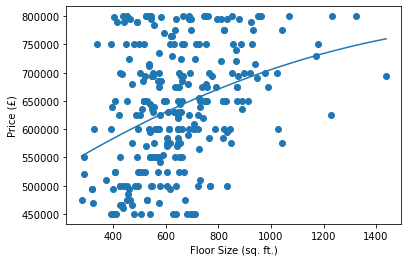

In [246]:
from matplotlib import pyplot as plt

x = df_varselect4['Floor_Size']
y = df_varselect4['Price']
a, b, c = np.polyfit(x, y, 2)

plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.scatter(x,y)

x2 = np.linspace(min(x), max(x), len(x))
y2 = a*(x2**2) + b*x2 + c
ax.plot(x2, y2)

ax.set_xlabel('Floor Size (sq. ft.)')
ax.set_ylabel('Price (£)')

plt.show()